<a href="https://colab.research.google.com/github/PremsaiKodi/House_Price_Prediction/blob/master/CNN4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

In [24]:
# Define constants
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 20

In [25]:
# Function for learning rate scheduling
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    return lr

In [26]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/My Drive'
train_data_dir = os.path.join(drive_path, '/content/drive/MyDrive/Training')
test_data_dir = os.path.join(drive_path, '/content/drive/MyDrive/Testing')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# Create data generators for training and testing with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [28]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [29]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 723 images belonging to 3 classes.


In [30]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 180 images belonging to 3 classes.


In [31]:
# Build the model with ResNet50 and custom layers
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

In [32]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))  # Assuming you have 3 classes/diseases

In [33]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [35]:
# Train the model
history = model.fit(train_generator, epochs=EPOCHS, validation_data=test_generator, callbacks=[lr_scheduler])

Epoch 1/20
23/23 [==============================] - 300s 12s/step - loss: 1.5686 - accuracy: 0.4288 - val_loss: 15078.2891 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - 232s 10s/step - loss: 1.0215 - accuracy: 0.5062 - val_loss: 742.6234 - val_accuracy: 0.3556 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - 238s 10s/step - loss: 0.9483 - accuracy: 0.5712 - val_loss: 2134.9744 - val_accuracy: 0.3556 - lr: 0.0010
Epoch 4/20
23/23 [==============================] - 230s 10s/step - loss: 0.8334 - accuracy: 0.6321 - val_loss: 4.2471 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 5/20
23/23 [==============================] - 234s 10s/step - loss: 0.7986 - accuracy: 0.6210 - val_loss: 1.1895 - val_accuracy: 0.3556 - lr: 0.0010
Epoch 6/20
23/23 [==============================] - 230s 10s/step - loss: 0.7855 - accuracy: 0.6584 - val_loss: 1.3400 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 7/20
23/23 [==============================] - 232s 10s/

In [36]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')

6/6 [==============================] - 14s 2s/step - loss: 2.2997 - accuracy: 0.3167
Test Accuracy: 0.3166666626930237


In [37]:
def predict_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMAGE_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)

    # Assuming classes are named 'class_0', 'class_1', 'class_2'
    class_names = ['Atelectasis', 'Cardiomelagy', 'Emphysema']

    result = {
        'class_name': class_names[class_index],
        'confidence': prediction[0][class_index]
    }

    return result

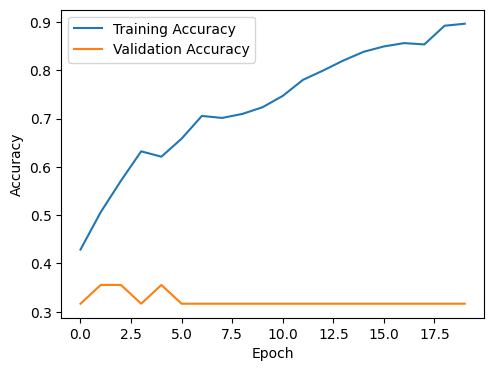

In [38]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [39]:
# Make predictions on test data
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

6/6 [==============================] - 15s 2s/step


Text(0.5, 1.0, 'Confusion Matrix')

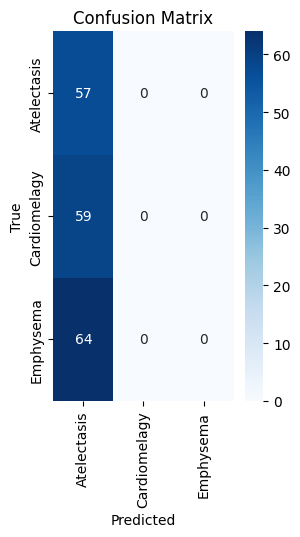

In [40]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

In [41]:
# Classification Report
class_report = classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys())
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

 Atelectasis       0.32      1.00      0.48        57
Cardiomelagy       0.00      0.00      0.00        59
   Emphysema       0.00      0.00      0.00        64

    accuracy                           0.32       180
   macro avg       0.11      0.33      0.16       180
weighted avg       0.10      0.32      0.15       180



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
# Calculate Precision
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
precision_dict = dict(zip(train_generator.class_indices.keys(), precision))
print('Precision:')
print(precision_dict)

Precision:
{'Atelectasis': 0.31666666666666665, 'Cardiomelagy': nan, 'Emphysema': nan}


<ipython-input-42-f51da6b23b37>:2: RuntimeWarning: invalid value encountered in divide
  precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)


In [51]:
# Example usage
new_image_path = '/content/drive/MyDrive/Checking/Atelectasis/00008042_008.png'
result = predict_image(new_image_path)
print(f"The model predicts: {result}")

1/1 [==============================] - 0s 184ms/step
The model predicts: {'class_name': 'Atelectasis', 'confidence': 0.90035194}
